# Sprint 1 - Project - 20210114

## Allocation of Resources for School Congestion in Elementary Schools


**Team Three Members:**
Hurly Cabalan | Joseph Figuracion | Mikee Sevilla | Phoemela Ballaran

**Team Three Mentor:**
Patrisha Estrada

----------------------

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

pd.set_option('max_colwidth', None)
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

----------------------


## Data Preparation

In [2]:
# Code for data checks + merging

import glob

masterlist = pd.read_csv('education_analytics/Masterlist of Schools.csv')
print(masterlist.shape)
print(masterlist.columns)

df_all = masterlist.copy()

files = glob.glob('education_analytics/*.csv')

for file in files:
    if 'Masterlist' not in file:
        try:
            file_df = pd.read_csv(file, encoding = 'utf-8')
        except:
            file_df = pd.read_csv(file, encoding = 'latin-1')
        
        if 'School ID' in file_df.columns:
            file_df = file_df.rename(columns = {'School ID':'school.id'})
        df_all = df_all.merge(file_df, on = 'school.id', how = 'left')

(46603, 23)
Index(['school.id', 'school.name', 'school.region', 'school.region.name',
       'school.province', 'school.cityhall', 'school.division',
       'school.citymuni', 'school.district', 'school.legdistrict',
       'school.type', 'school.abbrev', 'school.previousname',
       'school.mother.id', 'school.address', 'school.established',
       'school.classification', 'school.classification2',
       'school.curricularclass', 'school.organization', 'school.cityincome',
       'school.cityclass', 'school.urban'],
      dtype='object')


In [3]:
df_all = df_all[df_all['school.classification']=='Elementary']

In [4]:
df_all = df_all.drop(columns=['school.name_x','school.name_y', 'school.previousname', 'school.mother.id', 'school.address', 'school.cityclass', 'school.offering' ,'Region', 'Province','Municipality', 'Division', 'District', 'Offering', 'Name of Principal', 'Enrolment', 'school.cityhall', 'school.division', 'school.citymuni','Grade 7 Male', 'Grade 7 Female', 'Grade 8 Male',
       'Grade 8 Female', 'Grade 9 Male', 'Grade 9 Female', 'Grade 10 Male','Grade 10 Female', 'Grade 11 Male', 'Grade 11 Female', 'Grade 12 Male','Grade 12 Female', 'SPED NG Male_x', 'SPED NG Female_x',
       'school.district', 'school.classification','school.legdistrict','school.curricularclass'])

In [5]:
df_all.shape

(38689, 40)

In [6]:
df_all.columns

Index(['school.id', 'school.region', 'school.region.name', 'school.province',
       'school.type', 'school.abbrev', 'school.established',
       'school.classification2', 'school.organization', 'school.cityincome',
       'school.urban', 'Kinder Male', 'Kinder Female', 'Grade 1 Male',
       'Grade 1 Female', 'Grade 2 Male', 'Grade 2 Female', 'Grade 3 Male',
       'Grade 3 Female', 'Grade 4 Male', 'Grade 4 Female', 'Grade 5 Male',
       'Grade 5 Female', 'Grade 6 Male', 'Grade 6 Female', 'SPED NG Male_y',
       'SPED NG Female_y', 'School Name', 'Latitude', 'Longitude',
       'teachers.instructor', 'teachers.mobile', 'teachers.regular',
       'teachers.sped', 'rooms.standard.academic', 'rooms.standard.unused',
       'rooms.nonstandard.academic', 'rooms.nonstandard.unused',
       'school.enrollment', ' school.mooe '],
      dtype='object')

----------------------


## Feature Engineering

**Features:** Student/Teacher Ratio, Student per School Room, MOOE per Student

In [7]:
df_all['enrollees'] = df_all[df_all.columns[df_all.columns.str.contains('Male|Female')]].sum(axis=1)
df_all["allRooms"] = df_all["rooms.standard.academic"] + df_all["rooms.standard.unused"] + df_all["rooms.nonstandard.academic"] + df_all["rooms.nonstandard.unused"]
df_all['teachers'] = df_all['teachers.instructor'] + df_all['teachers.mobile'] + df_all['teachers.regular'] + df_all['teachers.sped']
df_all[" school.mooe "] = df_all[" school.mooe "].str.replace(",","").astype(float)

df_all = df_all[(df_all[' school.mooe ']!=0) & (df_all['enrollees']!=0) & (df_all['teachers']!=0) & (df_all['allRooms']!=0)]

df_all['student_teacher_ratio'] = df_all['enrollees'] / df_all['teachers']
df_all['mooe_student_ratio'] = df_all[" school.mooe "]/df_all["enrollees"]
df_all['student_per_rm'] = df_all['enrollees']/df_all['allRooms']

### Data checks

Particularly for st ratio, mooe per student, student per room, sped ratio, female to male ratio columns,

How do we deal with these data? Drop duplicates, missing, outliers.

- Are there missing values?

In [8]:
df_all.isna().sum()

school.id                         0
school.region                     0
school.region.name                0
school.province                   0
school.type                       0
school.abbrev                 24212
school.established                3
school.classification2            0
school.organization               0
school.cityincome               769
school.urban                      2
Kinder Male                       0
Kinder Female                     0
Grade 1 Male                      0
Grade 1 Female                    0
Grade 2 Male                      0
Grade 2 Female                    0
Grade 3 Male                      0
Grade 3 Female                    0
Grade 4 Male                      0
Grade 4 Female                    0
Grade 5 Male                      0
Grade 5 Female                    0
Grade 6 Male                      0
Grade 6 Female                    0
SPED NG Male_y                    0
SPED NG Female_y                  0
School Name                 

In [9]:
df_all = df_all.dropna(subset = ['student_teacher_ratio','student_per_rm','mooe_student_ratio'], how = 'any')

In [10]:
df_all.shape

(35848, 46)

- Are there duplicates? 

In [11]:
df_all[df_all["school.id"].duplicated(keep=False)].sort_values(by="school.id")

,school.id,school.region,school.region.name,school.province,school.type,school.abbrev,school.established,school.classification2,school.organization,school.cityincome,school.urban,Kinder Male,Kinder Female,Grade 1 Male,Grade 1 Female,Grade 2 Male,Grade 2 Female,Grade 3 Male,Grade 3 Female,Grade 4 Male,Grade 4 Female,Grade 5 Male,Grade 5 Female,Grade 6 Male,Grade 6 Female,SPED NG Male_y,SPED NG Female_y,School Name,Latitude,Longitude,teachers.instructor,teachers.mobile,teachers.regular,teachers.sped,rooms.standard.academic,rooms.standard.unused,rooms.nonstandard.academic,rooms.nonstandard.unused,school.enrollment,school.mooe,enrollees,allRooms,teachers,student_teacher_ratio,mooe_student_ratio,student_per_rm


- Are there outliers?

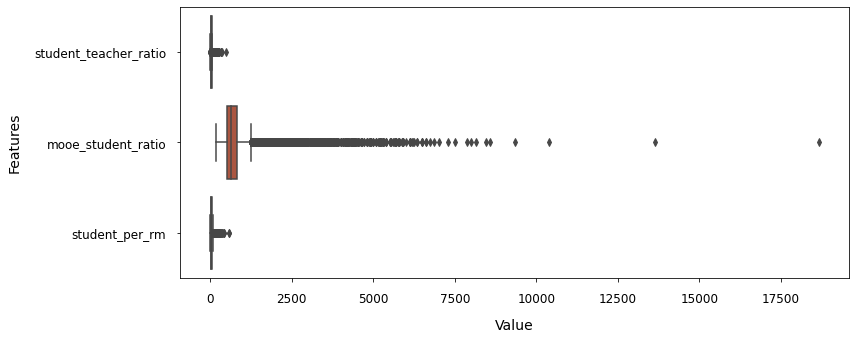

In [12]:
plt.figure(figsize=(12,5))
mycolors = ["#A6C3D0","#BD4C2F","#fccf55"]
melted = df_all[['student_teacher_ratio','mooe_student_ratio','student_per_rm',]].melt()
fig = sns.boxplot(x="value", y="variable", data=melted,palette=mycolors)
plt.xlabel("Value",fontsize=14,labelpad=13)
plt.ylabel("Features",fontsize=14,labelpad=13)
fig.tick_params(axis='both', which='major', labelsize=12,pad=10)
plt.show()

Removing outliers

In [13]:
engineeredColumns = ["student_per_rm","mooe_student_ratio","student_teacher_ratio"]

def removeOutlier(df,columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = (df[(df[column] >= Q1 - 1.5*IQR) & 
                (df[column] <= Q3 + 1.5*IQR)])
    return df

df_all = removeOutlier(df_all,engineeredColumns)

In [14]:
df_all.shape

(30566, 46)

In [15]:
df_all[['student_teacher_ratio','student_per_rm','mooe_student_ratio']].describe()

,student_teacher_ratio,student_per_rm,mooe_student_ratio
count,"30,566.00","30,566.00","30,566.00"
mean,37.87,39.25,667.57
std,10.41,12.33,192.75
min,9.24,9.00,335.29
25%,30.25,30.25,521.13
50%,37.17,38.00,620.69
75%,44.67,46.67,773.72
max,68.00,77.29,"1,277.78"


### Scaling

In [16]:
df_final = df_all.copy()

df_features = df_final[['student_teacher_ratio','student_per_rm','mooe_student_ratio']]
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

----------------------


## Modelling

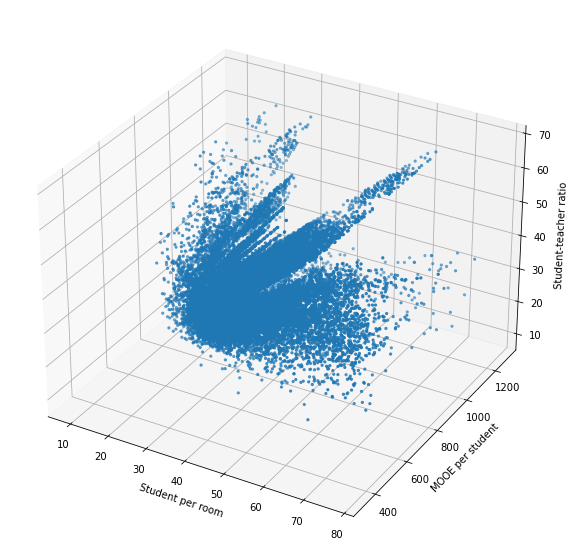

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

room = df_features['student_per_rm']
mooe = df_features['mooe_student_ratio']
st = df_features['student_teacher_ratio']
ax.scatter(room, mooe, st, s=5)

ax.set_xlabel('Student per room')
ax.set_ylabel('MOOE per student')
ax.set_zlabel('Student-teacher ratio')

plt.show()

### Using KMeans

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples


model = KMeans(n_clusters=3, random_state = 42)
model.fit(df_scaled)
cluster_labels = model.predict(df_scaled)

print(pd.Series(cluster_labels).value_counts())

2    13741
1     9003
0     7822
dtype: int64


Getting the silhouette score

In [19]:
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(3, silhouette_avg))

For n_clusters=3, the silhouette score is 0.34051547062514187


Add cluster labels

In [20]:
df_features['clusters'] = cluster_labels
df_features['clusters'].value_counts()

<ipython-input-20-80a7da497fc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['clusters'] = cluster_labels


2    13741
1     9003
0     7822
Name: clusters, dtype: int64

In [21]:
df_features.groupby('clusters')[["student_per_rm","mooe_student_ratio","student_teacher_ratio"]].mean()

,student_per_rm,mooe_student_ratio,student_teacher_ratio
clusters,,,
0,26.65,916.34,27.72
1,53.21,528.05,48.97
2,37.27,617.37,36.37


--------------------------------------------------
# Exploratory Data Analysis

### Mapping the engineered features per province

In [22]:
# Selecting boundaries of the areas
shapefile = gpd.read_file('map_data_clean/map_data_clean.shp')

In [23]:
# Create dictionary of those with discrepancy
province_dic = {'CITY OF COTABATO':'Maguindanao',
 'Manila, Ncr, First District':"Metropolitan Manila",
 'Ncr Fourth District':"Metropolitan Manila",
 'Ncr Second District':"Metropolitan Manila",
 'Ncr Third District':"Metropolitan Manila",
 'Western Sama':"Samar"}

In [24]:
# Replace province name
df_final["school.province"] = df_final["school.province"].str.title().replace(province_dic).str.replace("Del", 'del')

In [25]:
df_st_ratio = df_final.groupby("school.province")["student_per_rm","mooe_student_ratio","student_teacher_ratio"].mean().reset_index()
df_st_ratio

<ipython-input-25-4a939cb7cf2b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_st_ratio = df_final.groupby("school.province")["student_per_rm","mooe_student_ratio","student_teacher_ratio"].mean().reset_index()


,school.province,student_per_rm,mooe_student_ratio,student_teacher_ratio
0,Abra,27.17,870.90,26.08
1,Agusan del Norte,44.64,609.13,42.11
2,Agusan del Sur,46.07,643.42,42.24
3,Aklan,35.63,692.53,33.80
4,Albay,36.38,639.91,37.20
5,Antique,36.24,757.15,32.52
6,Apayao,32.36,837.57,34.20
7,Aurora,34.26,731.57,36.35
8,Bataan,40.90,563.53,42.02
9,Batanes,25.84,983.64,17.75


In [26]:
#Merge the shapefile and student-teacher ratio df
merged_data = pd.merge(shapefile, df_st_ratio, left_on='PROVINCE', right_on="school.province")

Mapping the mean of student/teacher ratio

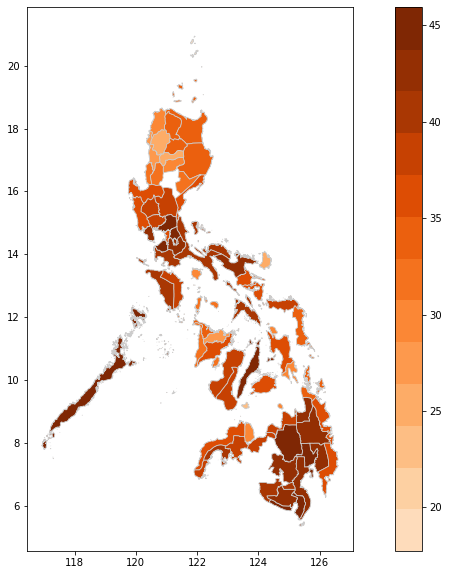

In [27]:
variable = "student_teacher_ratio"

vmin, vmax = merged_data["student_teacher_ratio"].min(), merged_data["student_teacher_ratio"].max()

fig, ax = plt.subplots(1, figsize=(15, 10))

cmap = mpl.cm.Oranges(np.linspace(-0.5,1,23))
cmap = mcolors.ListedColormap(cmap[10:,:-1])

merged_data.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
ax.grid(False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()

Mapping the mean of student per room ratio

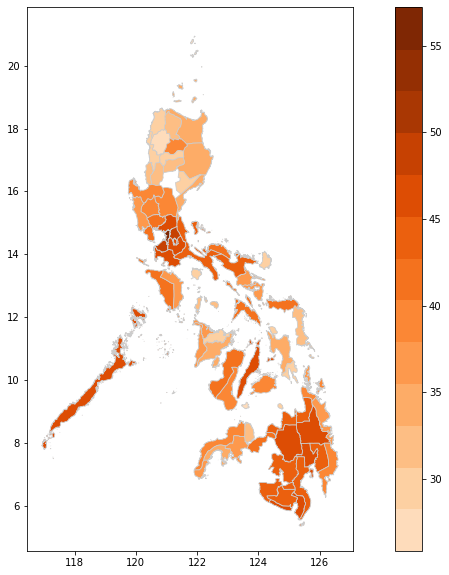

In [28]:
variable = "student_per_rm"


vmin, vmax = merged_data["student_per_rm"].min(), merged_data["student_per_rm"].max()

fig, ax = plt.subplots(1, figsize=(15, 10))

cmap = mpl.cm.Oranges(np.linspace(-0.5,1,23))
cmap = mcolors.ListedColormap(cmap[10:,:-1])

merged_data.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
ax.grid(False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()

Mapping the mean of MOOE per student ratio

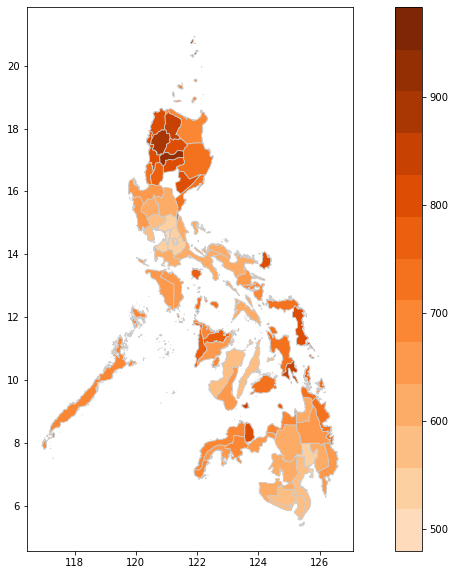

In [29]:
variable = "mooe_student_ratio"

vmin, vmax = merged_data["mooe_student_ratio"].min(), merged_data["mooe_student_ratio"].max()

fig, ax = plt.subplots(1, figsize=(15, 10))

cmap = mpl.cm.Oranges(np.linspace(-0.5,1,23))
cmap = mcolors.ListedColormap(cmap[10:,:-1])

merged_data.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
ax.grid(False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()

### Radar chart of the three clusters

In [30]:
df_features = df_features.rename(columns={'mooe_student_ratio' : 'MOOE Per Student Ratio','student_per_rm' : 'Student Per Room Ratio','student_teacher_ratio':'Student/Teacher Ratio'})

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df_features)

df_minmax = pd.DataFrame(df_minmax, index=df_features.index, columns=df_features.columns)

df_minmax['clusters'] = cluster_labels

df_clusters = df_minmax.set_index("clusters")
df_clusters = df_clusters.groupby("clusters").mean().reset_index()
df_clusters

,clusters,Student/Teacher Ratio,Student Per Room Ratio,MOOE Per Student Ratio
0,0,0.31,0.26,0.62
1,1,0.68,0.65,0.20
2,2,0.46,0.41,0.30


In [31]:

from math import pi
def make_spider( row, title, color):
 
    # number of variable
    categories=list(df_clusters)[1:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 3.5)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)
 
    # Draw ylabels
    ax.set_rlabel_position(0)

    plt.yticks([-0.25, 0, 0.25, 0.5, 0.75, 1], [-0.25, 0, 0.25, 0.5,0.75, 1], color="grey", size=7) #formmscaled
    plt.ylim(-0.25,1)

    # Ind1
    values=df_clusters.loc[row].drop('clusters').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=12, color=color, y=1.1)

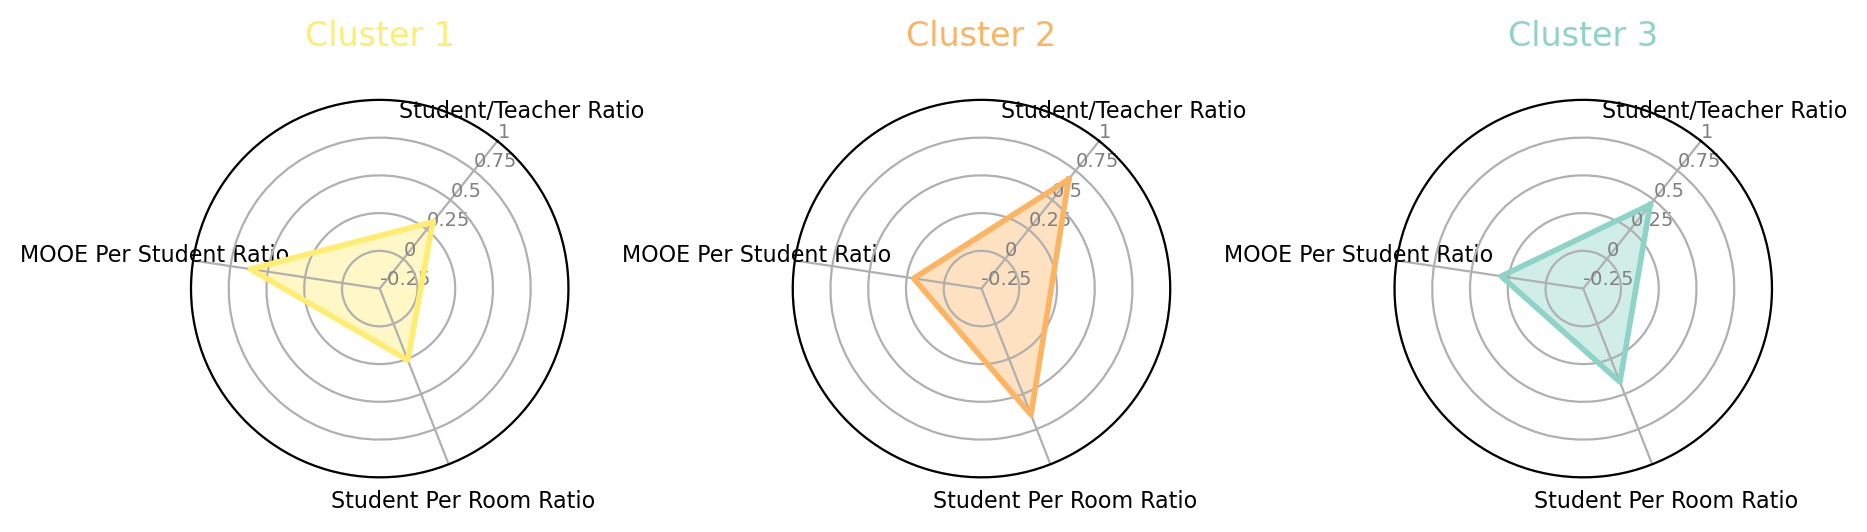

In [32]:
my_dpi=200
plt.figure(figsize=(2200/my_dpi, 2000/my_dpi), dpi=my_dpi)
plt.subplots_adjust(hspace=0.5)


# Create a color palette:
my_palette = plt.cm.get_cmap("Set3_r", len(df_clusters.index))

for row in range(0, len(df_clusters.index)):
    make_spider(row=row, 
                title='Cluster '+(df_clusters['clusters'][row]+1).astype(str), 
                color=my_palette(row))
plt.show()

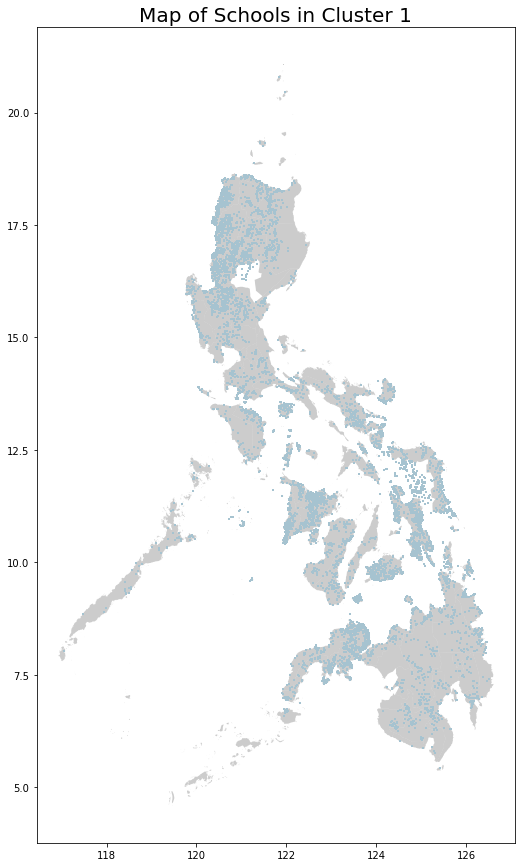

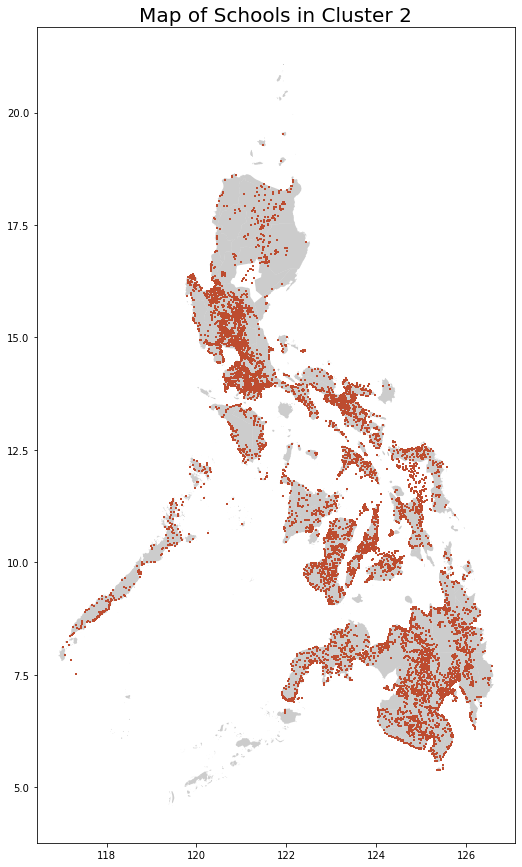

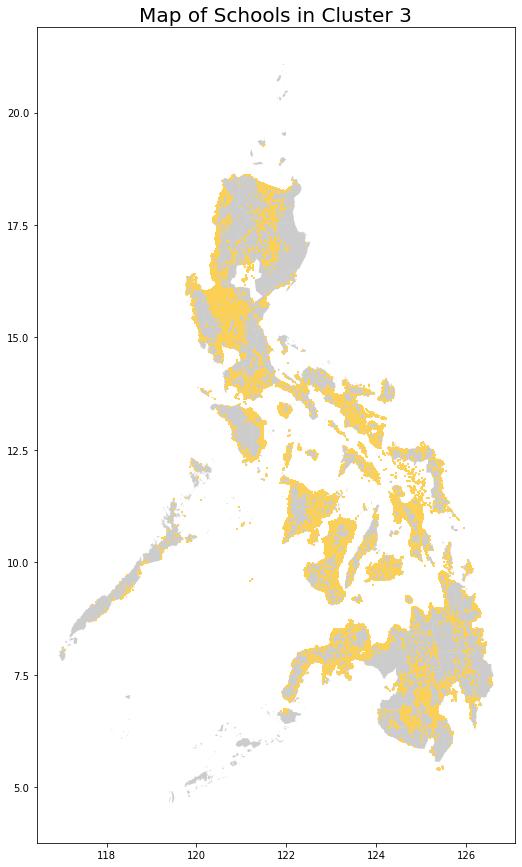

In [33]:
df_final['clusters'] = df_features['clusters']
df_map = df_final[df_final['Longitude']>100]

from shapely.geometry import Point, Polygon

geometry = [Point(xy) for xy in zip(df_map['Longitude'], df_map['Latitude'])]
geo_df = gpd.GeoDataFrame(df_map, geometry = geometry)
color = ["#A6C3D0","#BD4C2F","#FccF55"]

for i in range(3):
    fig, ax = plt.subplots(figsize=(15, 15))
    shapefile.plot(ax=ax, alpha = 0.4, color='grey')
    geo_df[geo_df['clusters']==i].plot(ax=ax, marker='+', color=color[i], markersize=8)
    plt.title("Map of Schools in Cluster " + str(i+1),fontsize=20)
    plt.show()

### School Management Classification Per Cluster

In [34]:
df_mgmt = df_final.groupby('clusters')['school.classification2'].value_counts().to_frame()
df_mgmt = df_mgmt.rename(columns={'school.classification2' : 'total_count'})
df_mgmt = df_mgmt.reset_index()
df_mgmt

,clusters,school.classification2,total_count
0,0,DepED Managed,7525
1,0,Local Government,297
2,1,DepED Managed,8707
3,1,Local Government,296
4,2,DepED Managed,13229
5,2,Local Government,512


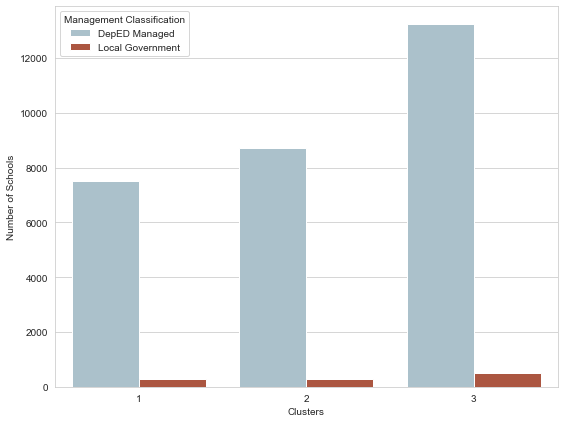

In [35]:
df_mgmt = df_mgmt.rename(columns={'school.classification2' : 'Management Classification'})
mycolors = ["#A6C3D0","#BD4C2F","#FccF55"]
sns.set_palette(sns.color_palette(mycolors))
sns.set_style("whitegrid")
plt.figure(figsize=(9,7))
sns.barplot(x='clusters', y='total_count', hue='Management Classification', data=df_mgmt)
plt.xlabel('Clusters')
plt.ylabel("Number of Schools")
plt.xticks(ticks = (0, 1, 2), labels = ['1', '2', '3'])
plt.show()

### School Organization Type Per Cluster

In [36]:
df_org = df_final.groupby('clusters')['school.organization'].value_counts().to_frame()
df_org = df_org.rename(columns={'school.organization' : 'count'})
df_org = df_org.reset_index()
df_org

,clusters,school.organization,count
0,0,Monograde,3966
1,0,Combined Monograde and Multigrade,3396
2,0,Multigrade,460
3,1,Monograde,7215
4,1,Combined Monograde and Multigrade,1622
5,1,Multigrade,166
6,2,Monograde,11470
7,2,Combined Monograde and Multigrade,2159
8,2,Multigrade,112


([<matplotlib.axis.XTick at 0x12b2b54c0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

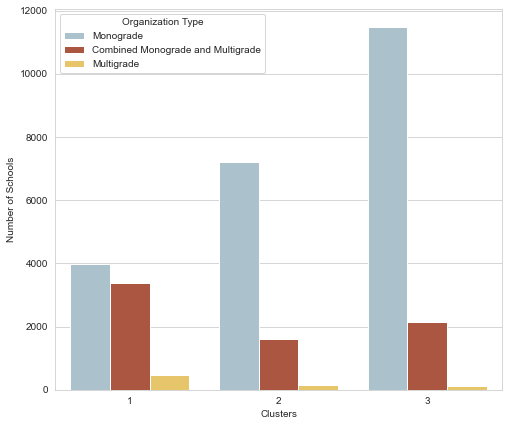

In [37]:
df_org = df_org.rename(columns={'school.organization' : 'Organization Type'})
mycolors = ["#A6C3D0","#BD4C2F","#FccF55"]
sns.set_palette(sns.color_palette(mycolors))
sns.set_style("whitegrid")
plt.figure(figsize=(8,7))
sns.barplot(x='clusters', y='count', hue='Organization Type', data=df_org)
plt.xlabel('Clusters')
plt.ylabel("Number of Schools")
plt.xticks(ticks = (0, 1, 2), labels = ['1', '2', '3'])

### SPED Opportunities Per Cluster

In [38]:
df_final['total_enrollees_sped'] = df_final['SPED NG Male_y'] + df_final['SPED NG Female_y']
spedcount=df_final.groupby("clusters")["total_enrollees_sped"].sum().to_frame().reset_index()
spedcount

,clusters,total_enrollees_sped
0,0,430.00
1,1,"14,776.00"
2,2,"11,144.00"


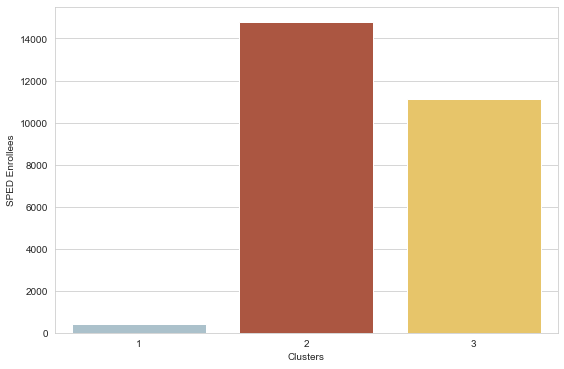

In [39]:
plt.figure(figsize=(9,6))
sns.barplot(x="clusters", y='total_enrollees_sped', data=spedcount)
plt.xlabel('Clusters')
plt.ylabel("SPED Enrollees")
plt.xticks(ticks = (0, 1, 2), labels = ['1', '2', '3'])
plt.show()